In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import keras 
import tensorflow as tf
import seaborn as sns
import warnings
import os
from PIL import Image

# Ignore all warnings
warnings.filterwarnings("ignore")

In [47]:
physical_devices = tf.config.list_physical_devices()
print("Physical devices:")
for device in physical_devices:
    print(device)

Physical devices:
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')


In [48]:

!echo "Number of images in test: " $(ls /kaggle/input/histopathologic-cancer-detection/train | wc -l)

!echo "Number of images in test: " $(ls /kaggle/input/histopathologic-cancer-detection/test | wc -l)


Number of images in test:  220025
Number of images in test:  57458


## EDA

### Competition

(description from Kaggle competition)

In this competition, you must create an algorithm to identify metastatic cancer in small image patches taken from larger digital pathology scans. The data for this competition is a slightly modified version of the PatchCamelyon (PCam) benchmark dataset (the original PCam dataset contains duplicate images due to its probabilistic sampling, however, the version presented on Kaggle does not contain duplicates).

PCam is highly interesting for both its size, simplicity to get started on, and approachability. In the authors' words:

 [PCam] packs the clinically-relevant task of metastasis detection into a straight-forward binary image classification task, akin to CIFAR-10 and MNIST. Models can easily be trained on a single GPU in a couple hours, and achieve competitive scores in the Camelyon16 tasks of tumor detection and whole-slide image diagnosis. Furthermore, the balance between task-difficulty and tractability makes it a prime suspect for fundamental machine learning research on topics as active learning, model uncertainty, and explainability. 
 
### Data Description

 In this dataset, you are provided with a large number of small pathology images to classify. Files are named with an image id. The train_labels.csv file provides the ground truth for the images in the train folder. You are predicting the labels for the images in the test folder. A positive label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue. Tumor tissue in the outer region of the patch does not influence the label. This outer region is provided to enable fully-convolutional models that do not use zero-padding, to ensure consistent behavior when applied to a whole-slide image.

The original PCam dataset contains duplicate images due to its probabilistic sampling, however, the version presented on Kaggle does not contain duplicates. We have otherwise maintained the same data and splits as the PCam benchmark.

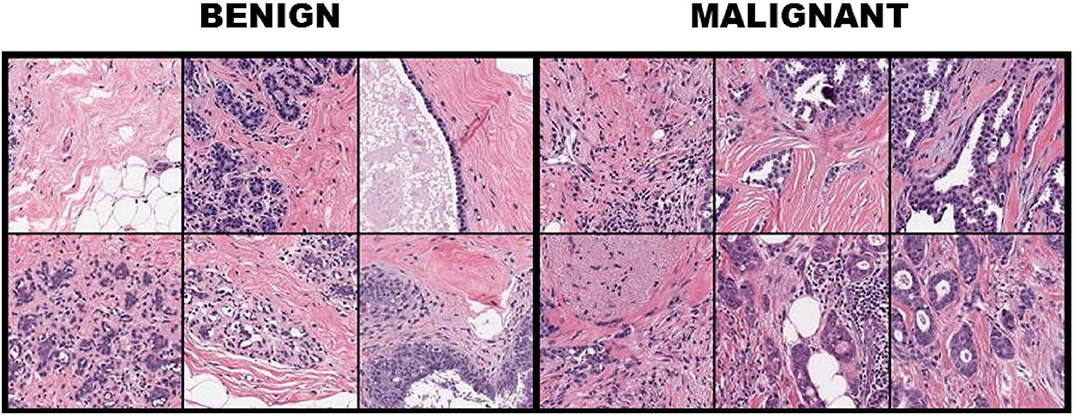


In [49]:
train_labels_df = pd.read_csv("/kaggle/input/histopathologic-cancer-detection/train_labels.csv")

train_labels_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


In [50]:
train_labels_df.head(10)


id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0
5  acfe80838488fae3c89bd21ade75be5c34e66be7      0
6  a24ce148f6ffa7ef8eefb4efb12ebffe8dd700da      1
7  7f6ccae485af121e0b6ee733022e226ee6b0c65f      1
8  559e55a64c9ba828f700e948f6886f4cea919261      0
9  8eaaa7a400aa79d36c2440a4aa101cc14256cda4      0

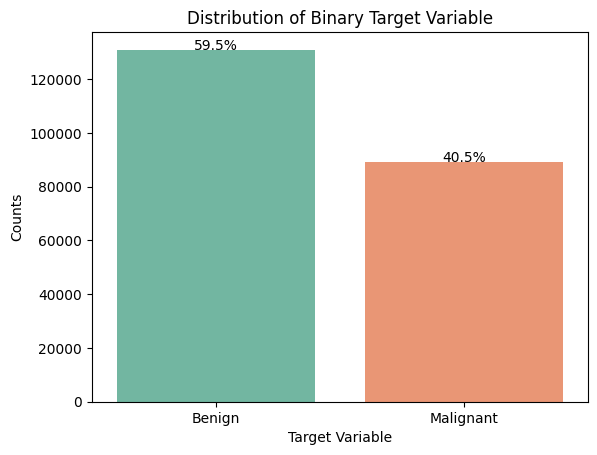

In [51]:
sns.countplot(x=["Benign" if l == 0 else "Malignant" for l in train_labels_df["label"]], 
              palette="Set2")

total = len(train_labels_df["label"])
for p in plt.gca().patches:
    height = p.get_height()
    plt.text(p.get_x() + p.get_width() / 2., height + 0.1, '{:.1f}%'.format((height / total) * 100),
             ha="center")

plt.xlabel('Target Variable')
plt.ylabel('Counts')
plt.title('Distribution of Binary Target Variable')
plt.show()


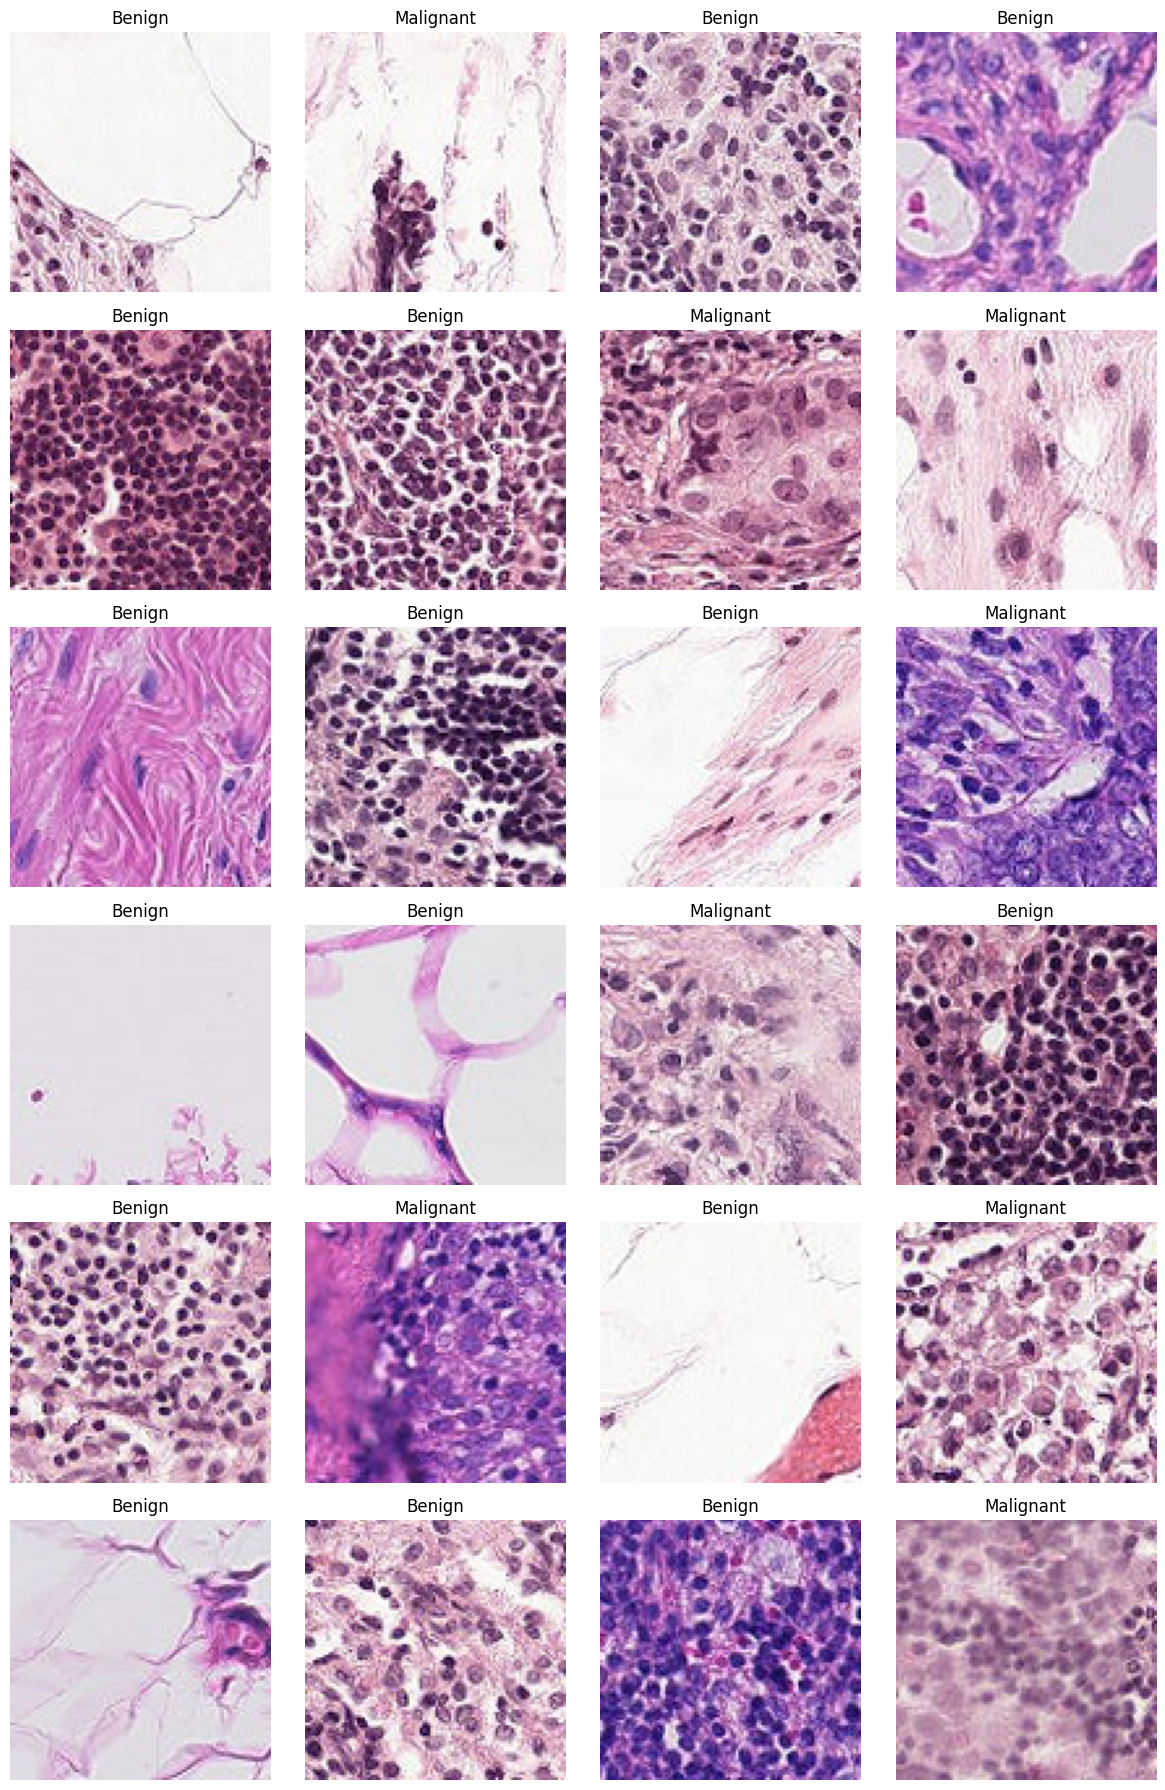

In [52]:
def display_images_in_grid(df, n):
    image_dir = "/kaggle/input/histopathologic-cancer-detection/train"

    # Create a grid of subplots
    num_rows = (n + 3) // 4  # Calculate number of rows needed
    fig, axes = plt.subplots(num_rows, 4, figsize=(12, 3 * num_rows))

    # Loop through the first n rows of the DataFrame
    for i, ax in enumerate(axes.flat):
        if i < n:
            # Construct the full path to the image file
            image_path = os.path.join(image_dir, df.iloc[i]['id'] + '.tif')

            # Load and display the image using PIL
            image = Image.open(image_path)
            image = image.resize((100, 100), Image.ANTIALIAS)
            ax.imshow(image, cmap='gray')
            ax.set_title("Benign" if df.iloc[i]['label'] == 0 else "Malignant")
            ax.axis('off')
        else:
            # Remove any extra subplot
            fig.delaxes(ax)

    # Adjust layout
    plt.tight_layout()

    # Show the plot
    plt.show()
    
    
display_images_in_grid(train_labels_df, 24)


### Data Splits



In [ ]:
from sklearn.model_selection import train_test_split
import shutil


image_dir = "/kaggle/input/histopathologic-cancer-detection/train"
train_dir = "/kaggle/working/splits/train"
dev_dir = "/kaggle/working/splits/dev"
test_dir = "/kaggle/working/splits/test"


shuffled_df = train_labels_df.sample(frac=1, random_state=42)

# Split dataframe into train, dev, and test sets
train_df, dev_test_df = train_test_split(shuffled_df, test_size=0.1, random_state=42)
dev_df, test_df = train_test_split(dev_test_df, test_size=0.5, random_state=42)

# Create directories if they don't exist
for directory in [train_dir, dev_dir, test_dir]:
    os.makedirs(directory, exist_ok=True)
    for class_label in train_labels_df['label'].unique():
        os.makedirs(os.path.join(directory, str(class_label)), exist_ok=True)

# Move images to corresponding directories
for df, directory in [(train_df, train_dir), (dev_df, dev_dir), (test_df, test_dir)]:
    for _, row in df.iterrows():
        image_name = row['id'] + '.tif'  # Assuming images are in JPEG format
        src_path = os.path.join(image_dir, image_name)
        dst_path = os.path.join(directory, str(row['label']), image_name)
        shutil.copy(src_path, dst_path)


### Image Generator with Data Augmentation
